# Data analysis

## 1. Necessary imports

In [1]:
# to retrieve files
import os.path
# for logging purposes
import logging
# for mathematical calculations on lists and dataframes
import numpy as np
# for CSV and dataframe operations
import pandas as pd
# for plots
import matplotlib.pyplot as plt
# for mathematical calculations
import math
# import the label encoder from sklearn
from sklearn.preprocessing import LabelEncoder
# for training and testing split
from sklearn.model_selection import train_test_split
# for the decision tree
from sklearn.tree import DecisionTreeClassifier
# to export and save it to JPG later on
from sklearn.tree import export_graphviz
# to export the tree structure
from sklearn.tree.export import export_text
# to save the log file name
from datetime import datetime

file_name_time = datetime.utcnow().strftime('%Y-%m-%d_%H_%M_%S_%f')[:-3]

__file__ = 'Data_analysis_' + file_name_time

# initializing the logger
logging.basicConfig(filename=os.getcwd() + '/../Log_files/' + __file__ + '.log',
                    filemode='a',
                    format='%(asctime)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)

logging.info("Initialized logger")
print("Initialized logger")

logging.info("File name time is " + file_name_time)
print("File name time is", file_name_time)

logging.info("#### Run started ####")

Initialized logger
File name time is 2023-09-22_19_50_54_128


C:\Users\berna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


## 2. Reading the data

In [2]:
# get the current working directory
print(os.getcwd())

C:\Users\berna\Google Drive\Work\Research_collab\Github_repositories\Vehicle_insurance_claim_fraud_detection\Jupyter_notebooks


In [3]:
# reading the dataset stored as CSV
data = pd.read_csv(os.getcwd() + '/../Dataset/fraud_oracle.csv')

# printing the first 5 rows of the dataframe
print(data.head())

  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years   

  AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0          26 to 30 

## 3. Showing class imbalance

In [4]:
# get the value counts
print(data['FraudFound_P'].value_counts())

print('\nNo. of records:', data.shape[0])

0    14497
1      923
Name: FraudFound_P, dtype: int64

No. of records: 15420


In [5]:
# storing the value counts
vc = data.FraudFound_P.value_counts()

# convert the value counts to a list
list_vc = vc.tolist()
list_vc

# convert the value counts to another list
vc_numbers_list = vc.to_list()

# get the total number of claims in the dataset
total = data.shape[0]

# convert the value counts to percentage of the total number of claims
list_vc = [round(l/total * 100, 2) for l in list_vc]
list_vc

[94.01, 5.99]

In [6]:
# getting the labels
s = vc.index.tolist()
s

[0, 1]

In [7]:
# setting new labels for plotting purposes only
s = ['Non_fraudulent', 'Fraudulent']

In [8]:
# setting the x-axis and printing it
yax = [text + ', ' + str(occ) + ', ' + str(perc) + '%' for text, occ, perc in zip(s, vc_numbers_list, list_vc)]
yax

['Non_fraudulent, 14497, 94.01%', 'Fraudulent, 923, 5.99%']

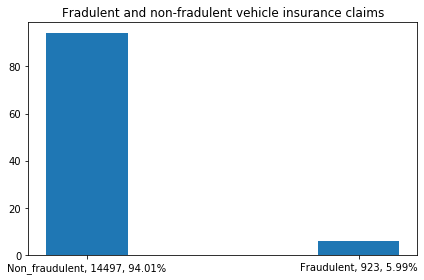

In [9]:
ticks = yax
data_for_plotting = list_vc
ind = np.arange(len(data_for_plotting))
fig = plt.figure(tight_layout=True) # need tight_layout to make everything fit
ax = plt.subplot(111)
ax.bar(ind, data_for_plotting, 0.3, align='center', label="%")
# plt.legend() - legend is useless in this plot
plt.title('Fradulent and non-fradulent vehicle insurance claims')
y_pos = range(len(yax))
plt.xticks(y_pos, yax)
plt.draw()  # this is needed because get_window_extent needs a renderer to work
plt.savefig(os.getcwd() + '/../Plots/claims_labels_' + file_name_time + '.png')
plt.draw()
plt.show()

## 4. Identifying outliers

https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/

In [10]:
# get some info about certain data
data.describe()[['Age', 'DriverRating']]

,Age,DriverRating
count,15420.000000,15420.000000
mean,39.855707,2.487808
std,13.492377,1.119453
min,0.000000,1.000000
25%,31.000000,1.000000
50%,38.000000,2.000000
75%,48.000000,3.000000
max,80.000000,4.000000


### This exercise was of not much help as the majority of the features are categorical, hence, we proceed with further analysis of the data.

## 5. Trying to identify concept drift

In [11]:
# first perform some pre-processing so that certain categorical features are converted to integer for sorting purposes

# get each unique value of each column to be mapped
print(data.MonthClaimed.unique())
print(data.DayOfWeekClaimed.unique())

['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']
['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']


In [12]:
# in the above cell we notice that there are certain errors in the data, 0 is not supposed to appear
# thus we check how many records there are which have 0 under any of the two above mentioned columns and we remove them

print('MonthClaimed:', data['MonthClaimed'].value_counts()['0'])
print('DayOfWeekClaimed:', data['DayOfWeekClaimed'].value_counts()['0'])

print('\nNo. of records before deletion:', data.shape[0])

# store new data for sorting to avoid mix ups
data_sorted = data

# remove the records with the invalid value under the specified columns
# parameter inplace is set to False (also by default) so that we return a copy of the modified dataframe and store it
# info retrieved from the official Pandas documentation - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
data_sorted = data_sorted.drop(data_sorted[data_sorted['MonthClaimed'] == '0'].index, inplace = False)
data_sorted = data_sorted.drop(data_sorted[data_sorted['DayOfWeekClaimed'] == '0'].index, inplace = False)

print('\nNo. of records after deletion:', data_sorted.shape[0])

# record removed

MonthClaimed: 1
DayOfWeekClaimed: 1

No. of records before deletion: 15420

No. of records after deletion: 15419


### Convert month and day of the week to integers for sorting purposes.

In [13]:
# we will map the months and days columns to an equivalent integer for sorting purposes
# create dictionaries - https://www.geeksforgeeks.org/replacing-strings-with-numbers-in-python-for-data-analysis/

MonthClaimed_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
DayOfWeekClaimed_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

# iterate the column which requires the mapping in the dataframe, get the current iterated month, fetch it in the dictionary, retrieve the mapping from the dictionary and place it in
# a new column in the same dataset
data_sorted['MonthClaimed_int'] = [MonthClaimed_dict[month] for month in data_sorted.MonthClaimed]
data_sorted['DayOfWeekClaimed_int'] = [DayOfWeekClaimed_dict[day] for day in data_sorted.DayOfWeekClaimed]

data_sorted.head()

# mapping applied

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MonthClaimed_int,DayOfWeekClaimed_int
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,No,No,External,none,1 year,3 to 4,1994,Liability,1,2
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,Yes,No,External,none,no change,1 vehicle,1994,Collision,1,1
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,No,No,External,none,no change,1 vehicle,1994,Collision,11,4
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,7,5
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,No,No,External,none,no change,1 vehicle,1994,Collision,2,2


### Now sort the data.

In [14]:
# store a new data set which is sorted first with Year -> MonthClaimed -> WeekOfMonthClaimed -> DayOfWeekClaimed (all in ascending order)
data_sorted = data_sorted.sort_values(['Year', 'MonthClaimed_int', 'WeekOfMonthClaimed', 'DayOfWeekClaimed_int'], ascending=[True, True, True, True], inplace = False)

# reset the index
data_sorted = data_sorted.reset_index(drop=True)

# store the dataset as CSV
data_sorted.to_csv(os.getcwd() + '\\..\\Dataset\\fraud_oracle_sorted_' + file_name_time + '.csv')

data_sorted.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MonthClaimed_int,DayOfWeekClaimed_int
0,Oct,4,Tuesday,Chevrolet,Urban,Monday,Jan,1,Male,Married,...,No,No,External,none,no change,1 vehicle,1994,All Perils,1,1
1,Dec,1,Wednesday,Honda,Urban,Monday,Jan,1,Male,Single,...,No,No,External,none,4 to 8 years,2 vehicles,1994,Liability,1,1
2,Jan,1,Saturday,Chevrolet,Urban,Monday,Jan,1,Male,Married,...,No,No,External,more than 5,no change,1 vehicle,1994,Liability,1,1
3,Dec,2,Monday,Mazda,Urban,Monday,Jan,1,Male,Married,...,No,No,External,none,4 to 8 years,2 vehicles,1994,All Perils,1,1
4,Dec,3,Thursday,Honda,Urban,Monday,Jan,1,Male,Married,...,No,No,External,none,no change,1 vehicle,1994,Collision,1,1


In [15]:
# create a new data frame and store the years and month in it (at this stage they are now sorted)
dates = pd.DataFrame()
dates['Year'] = data_sorted['Year']
dates['MonthClaimed'] = data_sorted['MonthClaimed']

# drop any duplicates
dates = dates.drop_duplicates()

# reset the dataframe index
dates = dates.reset_index(drop = True)

dates.head()

,Year,MonthClaimed
0,1994,Jan
1,1994,Feb
2,1994,Mar
3,1994,Apr
4,1994,May


### Now we collect the number of fraudulent claims per year, and then month, so that we can plot fraudulent claims per month.

In [16]:
fraud_claims = []

# iterate over each year and month to get the fraudulent claims per month
for year, month in zip(dates['Year'], dates['MonthClaimed']):
    # append the total no of fraudulent claims for a certain month
    fraud_claims.append(len(data_sorted[(data_sorted['Year'] == year) & (data_sorted['MonthClaimed'] == month) & (data_sorted['FraudFound_P'] == 1)].index))

# add the collected data to the dataframe storing the year and month
dates['fraud_claims'] = fraud_claims

# for verification purposes
print('Total no. of fraudulent claims:', np.sum(fraud_claims))

print(dates.head())

dates.to_csv(os.getcwd() + '/../Stats/fraud_claims_per_month_' + file_name_time + '.csv')

Total no. of fraudulent claims: 923
   Year MonthClaimed  fraud_claims
0  1994          Jan            46
1  1994          Feb            38
2  1994          Mar            45
3  1994          Apr            52
4  1994          May            58


### Plot the fraudulent claims per month.

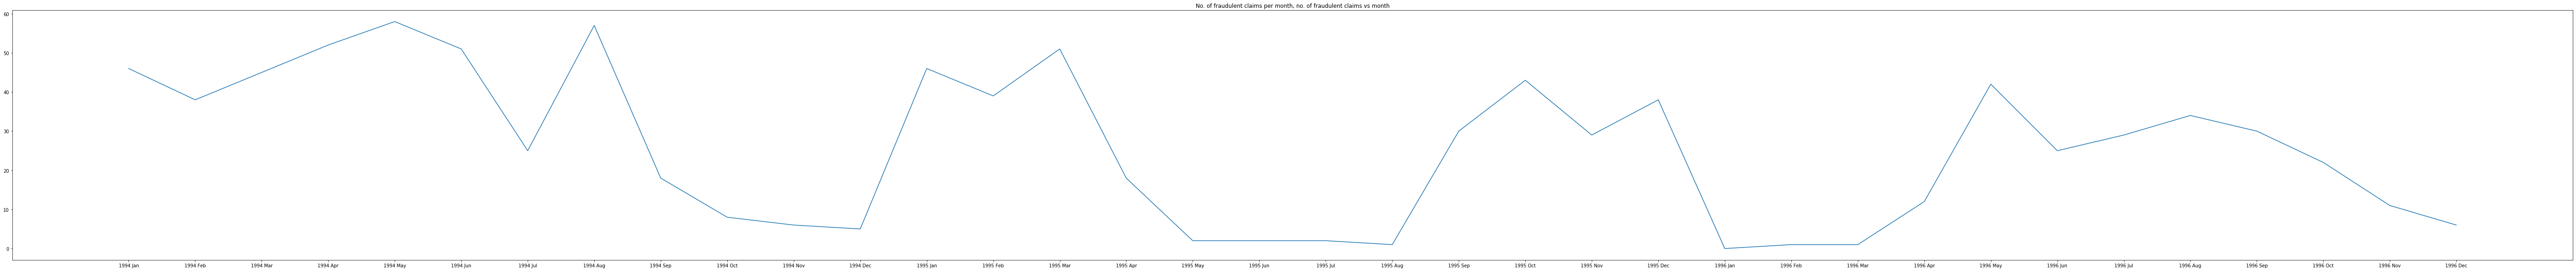

In [17]:
plt.figure(figsize=(100,10))

# set the x-axis
x_axis = [str(year) + ' ' + month for year, month in zip(dates['Year'], dates['MonthClaimed'])]

plt.plot(x_axis, dates['fraud_claims'])
plt.title("No. of fraudulent claims per month, no. of fraudulent claims vs month")
plt.savefig(os.getcwd() + '/../Plots/fraudulent_claims_per_month_' + file_name_time + '.png', bbox_inches='tight')
plt.show()

### Although we have a very small amount of data, we can see that the data is not stationary. Thus, we continue investigating.

### From here onwards we build decision trees and check their structure.

In [18]:
# these settings were chosen arbitrarily
window_size = 5000
step = 1000

# forgot the source of this equation
num_of_iterations = math.ceil(((len(data_sorted.index)-window_size)/step)+1)

print(num_of_iterations)

12


In [19]:
def get_feature_number(text):
    text_after = text.split("|--- ",1)[1]
    number = text_after.split(" ", 1)[0]
    return int(number.split("_",1)[1])

In [20]:
def get_feature_level(text):
    return text.count('|   ')

### Create a column consisting of the Year and MonthClaimed joined into one single column.

In [21]:
data_sorted['YearMonthClaimed'] = [str(year) + ' ' + month for year, month in zip(data_sorted['Year'], data_sorted['MonthClaimed'])]

### First we get the number of claims per generated window.

In [22]:
# dataframe for the Year and MonthClaimed frequency count
dates_freq = pd.DataFrame({'YearMonthClaimed': data_sorted.YearMonthClaimed.unique()})

# also create two seperate columns for the Year and MonthClaimed
dates_freq['Year'] = dates.Year
dates_freq['MonthClaimed'] = dates.MonthClaimed

# another dataframe to use during the window generation process
data_to_use = data_sorted

# retrieve the records and do frequency counts for Year and MonthClaimed per window
for i in range(0, num_of_iterations):
    
    # this dataframe is used to generate the windows
    to_use = pd.DataFrame()
    
    if len(data_to_use.index) >= window_size:
    
        # retrieve the first number of records using the window size
        to_use = data_to_use.head(window_size)
        
        # remove the first n (step size) rows
        data_to_use = data_to_use.iloc[step:]
        
    else:
        
        # retrieve the first number of records using the size of the dataframe since it's the last window
        to_use = data_to_use.head(len(data_to_use.index))
    
    # get the frequency counts of the Year and MonthClaimed
    dates_freq['tree_' + str(i)] = dates_freq['YearMonthClaimed'].map(to_use['YearMonthClaimed'].value_counts())

In [23]:
# save the YearMonthClaimed frequency per window tree to csv
dates_freq.to_csv(os.getcwd() + '/../Stats/dates_freq_' + file_name_time+ '.csv')

In [24]:
# print the column names
data_sorted.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy', 'MonthClaimed_int', 'DayOfWeekClaimed_int',
       'YearMonthClaimed'],
      dtype='object')

In [25]:
# identify which features to keep
# removed RepNumber, PolicyNumber, MonthClaimed_int, DayOfWeekClaimed_int
featuresToKeep = ['Month', 'WeekOfMonth', 'DayOfWeek','Make','AccidentArea', 
                 'DayOfWeekClaimed','MonthClaimed','WeekOfMonthClaimed', 
                 'Sex','MaritalStatus','Age', 
                 'Fault','PolicyType','VehicleCategory',
                 'VehiclePrice','Deductible','DriverRating', 
                 'Days_Policy_Accident','Days_Policy_Claim','PastNumberOfClaims','AgeOfVehicle', 
                 'AgeOfPolicyHolder','PoliceReportFiled','WitnessPresent',
                 'AgentType', 'NumberOfSuppliments','AddressChange_Claim', 
                 'NumberOfCars', 'BasePolicy', 'Year', 'FraudFound_P']

data_sorted = data_sorted[featuresToKeep]

In [26]:
# function that applies label encoding to the string categorical features
def apply_label_encoding(data):
    
    # creating instance of labelencoder
    labelencoder = LabelEncoder()
    
    # Assigning numerical values and storing in another column
    data['Month'] = labelencoder.fit_transform(data['Month'])
    data['DayOfWeek'] = labelencoder.fit_transform(data['DayOfWeek'])
    data['Make'] = labelencoder.fit_transform(data['Make'])
    data['AccidentArea'] = labelencoder.fit_transform(data['AccidentArea'])
    data['DayOfWeekClaimed'] = labelencoder.fit_transform(data['DayOfWeekClaimed'])
    data['MonthClaimed'] = labelencoder.fit_transform(data['MonthClaimed'])
    data['Sex'] = labelencoder.fit_transform(data['Sex'])
    data['MaritalStatus'] = labelencoder.fit_transform(data['MaritalStatus'])
    data['Fault'] = labelencoder.fit_transform(data['Fault'])
    data['PolicyType'] = labelencoder.fit_transform(data['PolicyType'])
    data['VehicleCategory'] = labelencoder.fit_transform(data['VehicleCategory'])
    data['VehiclePrice'] = labelencoder.fit_transform(data['VehiclePrice'])
    data['Days_Policy_Accident'] = labelencoder.fit_transform(data['Days_Policy_Accident'])
    data['Days_Policy_Claim'] = labelencoder.fit_transform(data['Days_Policy_Claim'])
    data['PastNumberOfClaims'] = labelencoder.fit_transform(data['PastNumberOfClaims']) # has certain cells as null
    data['AgeOfVehicle'] = labelencoder.fit_transform(data['AgeOfVehicle'])
    data['AgeOfPolicyHolder'] = labelencoder.fit_transform(data['AgeOfPolicyHolder'])
    data['PoliceReportFiled'] = labelencoder.fit_transform(data['PoliceReportFiled'])
    data['WitnessPresent'] = labelencoder.fit_transform(data['WitnessPresent'])
    data['AgentType'] = labelencoder.fit_transform(data['AgentType'])
    data['NumberOfSuppliments'] = labelencoder.fit_transform(data['NumberOfSuppliments'])
    data['AddressChange_Claim'] = labelencoder.fit_transform(data['AddressChange_Claim'])
    data['NumberOfCars'] = labelencoder.fit_transform(data['NumberOfCars'])
    data['BasePolicy'] = labelencoder.fit_transform(data['BasePolicy'])
    
    
    return data

# apply the label encoding to the selected categorical features
data_sorted = apply_label_encoding(data_sorted)

In [27]:
data_sorted.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy,Year,FraudFound_P
0,10,4,5,2,1,1,4,1,1,1,...,4,0,0,0,3,3,0,0,1994,0
1,2,1,6,6,1,1,4,1,1,2,...,0,0,0,0,3,2,1,2,1994,0
2,4,1,2,2,1,1,4,1,1,1,...,5,0,0,0,2,3,0,2,1994,0
3,2,2,1,9,1,1,4,1,1,1,...,5,0,0,0,3,2,1,0,1994,1
4,2,3,4,6,1,1,4,1,1,1,...,5,0,0,0,3,3,0,1,1994,1


In [28]:
orig_df = data_sorted

df = data_sorted

# create a dataframe which will store the feature levels
index = df.columns.tolist()
index.remove('FraudFound_P')
feature_levels = pd.DataFrame({'features': index})

# create a column to store the number of NAs for each feature
feature_levels['all_NAs'] = False
feature_levels['no_of_NAs'] = 0
feature_levels['no_of_times_root'] = 0

logging.info("Will generate the windows")
print("Will generate the windows...")

# lists for number of nodes and tree number
no_of_nodes = []
tree_depth = []
tree_column = []

# to store the window sizes
window_sizes = []

# retrieve the records and create decision trees
for i in range(0, num_of_iterations):

    to_use = pd.DataFrame()
    
    if len(df.index) >= window_size:
    
        # retrieve the first number of records using the window size
        to_use = df.head(window_size)
        
        # remove the first n (step size) rows
        df = df.iloc[step:]
        
    else:
        
        # retrieve the first number of records using the size of the dataframe since it's the last window
        to_use = df.head(len(df.index))
    
    # append the size of the windows
    window_sizes.append(len(to_use.index))
        
    # print("Size of window is", str(len(to_use.index)))     
    
    # initialize the decision tree
    dt = DecisionTreeClassifier(criterion='entropy')
    
    #dt = DecisionTreeClassifier(criterion='entropy', splitter='random',
                                #max_depth=10, min_samples_split=2,
                                #min_samples_leaf=10,
                                #max_leaf_nodes=None, class_weight='balanced')
    
    # split the label and rest of the data
    y = to_use['FraudFound_P']
    X = to_use.drop('FraudFound_P', axis=1)

    # split the sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle = False)
    
    # train the decision tree
    dt = dt.fit(X_train, y_train)

    logging.info("Decision tree " + str(i) + " created")

    export_graphviz(dt, out_file=os.getcwd() + '/../Dot_files/tree_' + str(i) + '_' + file_name_time + '.dot', feature_names=X_train.columns,
                    class_names=['0', '1'],
                    rounded=True, proportion=False, precision=2, filled=True)
    
    # new df for the most important features
    most_important_features = pd.DataFrame(columns = ['tree_number', 'feature', 'feature_number'])
    
    # BM continue here
    
    # top 5 important features
    # counter to rank the top 5 most important features
    c = 0
    logging.info('The top 5 most importand features:')
    for importance, name in sorted(zip(dt.feature_importances_, X_train.columns), reverse=True)[:len(df.columns)]:
        logging.info(name + " " + str(importance))
        c += 1
        most_important_features.loc[len(most_important_features.index)] = ['tree_' + str(i), name, c]
    
    # now save the CSV
    most_important_features.to_csv(os.getcwd() + '/../Tree_structures/most_important_features_' + file_name_time + '.csv')
    
    logging.info("Number of nodes for tree " + str(i) + " is " + str(dt.tree_.node_count))
    
    # append the number of nodes
    no_of_nodes.append(dt.tree_.node_count)
    tree_depth.append(dt.tree_.max_depth)
    tree_column.append('tree_' + str(i))
    
    # get the tree rules
    tree_rules = export_text(dt)
    tree_rules_with_feature_names = export_text(dt, feature_names = X_train.columns.tolist())
    
    text_file = open(os.getcwd() + "/../Tree_structures/tree_" + str(i) + "_structure_" + file_name_time + ".txt", "w")
    text_file.write(tree_rules_with_feature_names)
    text_file.close()
    
    # create a column for the current tree
    feature_levels['tree_' + str(i)] = 'NA'
    
    # check each line
    for line in tree_rules.splitlines():
        if 'class' not in line and 'truncated' not in line:
            level = get_feature_level(line)
            feature_number = get_feature_number(line)
            
            # add the feature level
            if feature_levels.at[feature_number, 'tree_' + str(i)]== 'NA':
                feature_levels.loc[feature_number, 'tree_' + str(i)] = ',' + str(level)
            elif str(level) not in feature_levels.iloc[feature_number]['tree_' + str(i)]:
                feature_levels.loc[feature_number, 'tree_' + str(i)] = feature_levels.iloc[feature_number]['tree_' + str(i)] + ',' + str(level)
        
    logging.info("\n")
    
print("Trees generated")

Will generate the windows...
Trees generated


### Plotting the number of nodes and depth of each tree

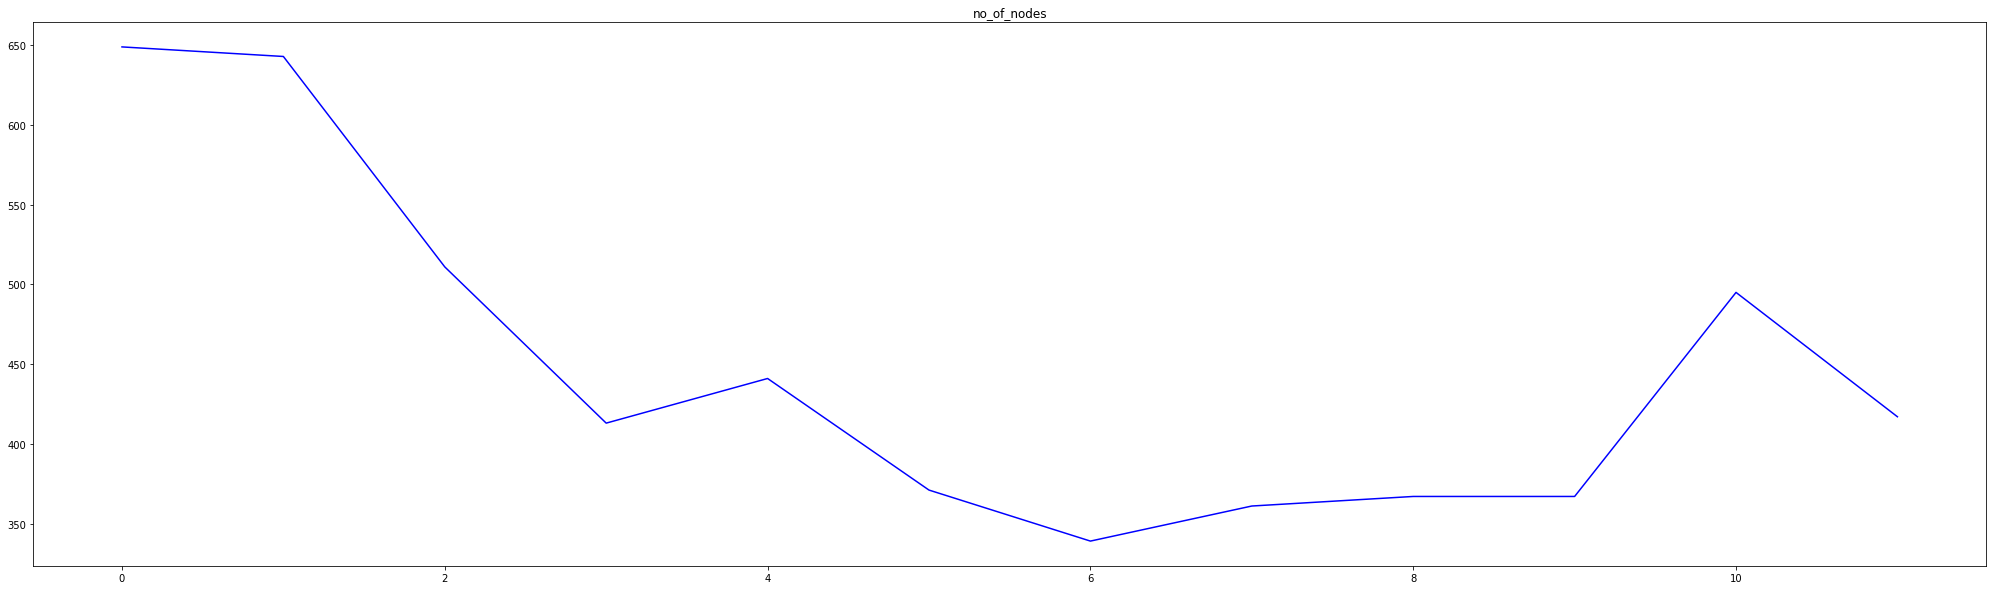

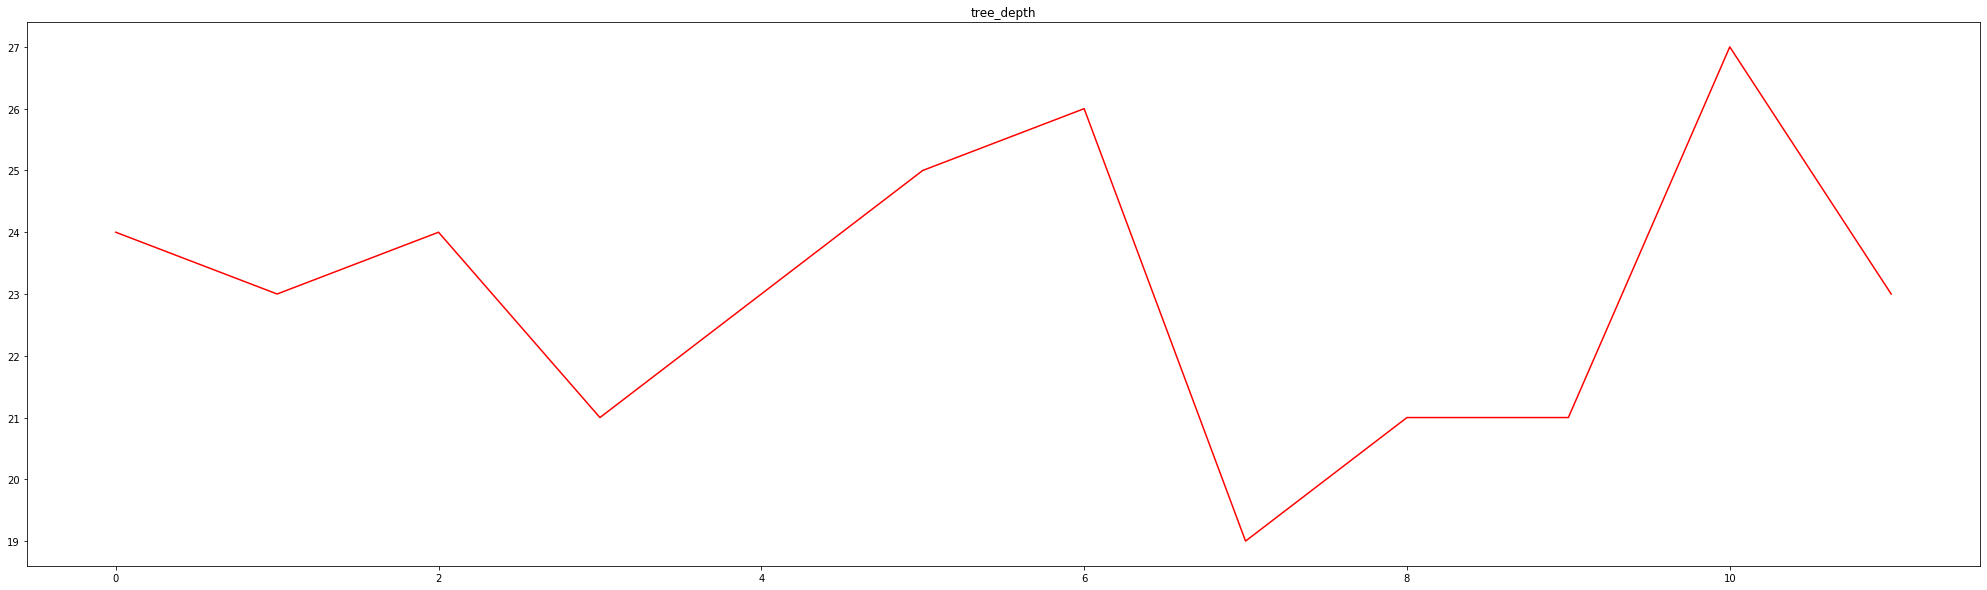

In [29]:
# plot the number of nodes for each tree
plt.figure(figsize=(35,10))
plt.title('no_of_nodes')
plt.plot(no_of_nodes, "-b")
plt.savefig(os.getcwd() + '/../Plots/no_of_nodes_per_tree_' + file_name_time + '.png')

plt.figure(figsize=(35,10))
plt.title('tree_depth')
plt.plot(tree_depth, "-r")
plt.savefig(os.getcwd() + '/../Plots/tree_depth_per_tree_' + file_name_time + '.png')

### Computing the number of times that a feature did not appear in a tree, and the number of times a feature was the root of the tree

In [30]:
# compute further information
feature_levels_list = feature_levels.values.tolist()

# store a counter to access the dataframe index
count = 0

# iterate each row
for row in feature_levels_list:
    # count the number of NAs in a row
    no_of_NAs = row.count('NA')
    feature_levels.loc[count, 'no_of_NAs'] = no_of_NAs
    
    # find how much times feature was a root
    no_of_times_root = 0
    for item in row[4:]:
        if item.count(',0,') > 0:
            no_of_times_root += 1
    feature_levels.loc[count, 'no_of_times_root'] = no_of_times_root    
    
    # mark if all NAs
    if no_of_NAs == len(row) - 4:
        print(feature_levels.loc[count, 'features'], 'did not appear once in a tree')
        feature_levels.loc[count, 'all_NAs'] = True
    
    # increase counter
    count += 1

In [31]:
# save the dataframe with the feature levels
feature_levels.to_csv(os.getcwd() + '/../Tree_structures/feature_levels_' + file_name_time + '.csv', index = False)

In [32]:
# save the dataframe with the number of nodes
df_no_of_nodes = pd.DataFrame({'tree': tree_column, 'no_of_nodes': no_of_nodes, 'tree_depth': tree_depth, 'window_sizes': window_sizes})
df_no_of_nodes.to_csv(os.getcwd() + '/../Tree_structures/tree_stats_' + file_name_time + '.csv', index = False)

In [33]:
logging.info("#### Run finished ####")